In [1]:
import json

import mlflow
import pandas as pd
from lightgbm import LGBMRegressor
from mlem.api import build, save
from pandas_profiling import ProfileReport
from pycaret.regression import (
    compare_models,
    create_model,
    eda,
    evaluate_model,
    get_config,
    interpret_model,
    tune_model,
    plot_model,
    setup,
    set_config,
)
from pycaret.internal.preprocess.transformers import TransformerWrapper
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.model_selection import cross_validate, KFold, train_test_split

***

### Config

In [2]:
# Some houskeeping stuff
mlflow.set_tracking_uri("http://mlflow:5000")
MODELS = ["lr", "lightgbm", "rf", "et", "dummy", "xgboost"]
SESSION_ID = 42

# Will use this dataframe to train a baseline model
raw_data = pd.read_csv("house_prices.csv", dtype={"spaciousness": "int64"})

# This data will be used for training the candidate model(s).
data = pd.read_csv("house_prices.csv", dtype={"spaciousness": "int64"})
data = data.rename(columns={"sale_price": "target"})

### Examine pandas_profiling report

In [3]:
ProfileReport(raw_data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

***

### Raw dataset adjustments

By looking at the profile above, we can identify some irregularities with the dataset. In order to have a cleaner dataset, the folowing changes were made:

- Removed `has_pool` since it has constant 0 value
- Removed `liv_lot_ratio` as being binary does not match with the feature's description of being a ratio
- Removed negative `remodel_age` values
- Only `house_age` greater or equal to `garage_age`, assuming garage can not be older than the house

In [4]:
data = data.drop(columns=[
    "has_pool",
    "liv_lot_ratio",
])
data = data[data["remodel_age"] >= 0]
data = data[(data["house_age"] >= data["garage_age"]) | (data["garage_age"].isna())]
data.shape

(33011, 16)

***

### Baseline

Test multiple models with base dataset

In [5]:
setup(
    data,
    session_id=SESSION_ID,
    target="target",
    log_experiment=True,
)
baseline = compare_models(include=MODELS)

***

### Custom preprocessing

Let's create a custom preprocessing pipeline and test it with the best previous model

In [6]:
categorical_columns = ["house_style", "neighborhood"]
numeric_columns = [
    "property_area",
    "house_age",
    "spaciousness",
    "remodel_age",
    "bath_area",
    "bsmt_area",
    "garage_area",
    "garage_age",
]
ordinal_columns = [
    "overall_quality",
    "overall_condition"
]
binary_columns = [
    "has_2ndfloor",
    "has_porch",
    "has_multiple_kitchen",
]

preprocessing = Pipeline([
    ("categorical_imputer", TransformerWrapper(transformer=SimpleImputer(strategy="most_frequent"), include=categorical_columns)),
    ("numerical_imputer", TransformerWrapper(transformer=SimpleImputer(strategy="mean"), include=numeric_columns)),
    ("ordinal_imputer", TransformerWrapper(transformer=SimpleImputer(strategy="median"), include=ordinal_columns)),
    ("binary_imputer", TransformerWrapper(transformer=SimpleImputer(strategy="most_frequent"), include=binary_columns)),
    ("categorical_encoding", TransformerWrapper(transformer=OneHotEncoder(drop="first", handle_unknown="infrequent_if_exist"), include=categorical_columns)),
])

setup(
    data,
    session_id=SESSION_ID,
    target="target",
    log_experiment=True,
    transform_target=True,
    preprocess=False,
    custom_pipeline=preprocessing,
)

candidate = create_model("lightgbm")

***

### Tuning

Finally, let's fine tune the model to see if we can get even better performance

In [7]:
tuned = tune_model(candidate, search_library="optuna", n_iter=50)

[I 2023-02-13 15:52:35,406] Searching the best hyperparameters using 23107 samples...


[LightGBM] [Warning] bagging_fraction is set=0.8689948231919535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8689948231919535
[LightGBM] [Warning] feature_fraction is set=0.5536101982241411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5536101982241411
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.6435240907732596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6435240907732596
[LightGBM] [Warning] feature_fraction is set=0.860616208331412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.860616208331412
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7101192029818408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7101192029818408
[LightGBM] [Warning] feature_fraction

[I 2023-02-13 16:03:15,927] Finished hyperparemeter search!


### Model evaluation and explainability

In [8]:
evaluate_model(tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

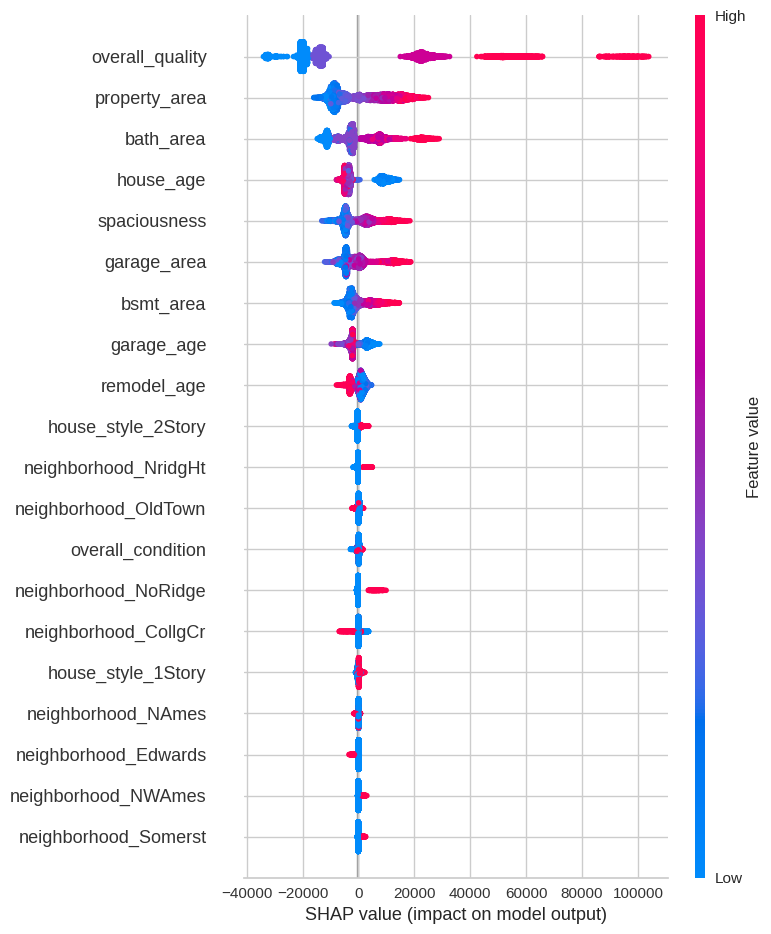

In [9]:
interpret_model(tuned)

### Train-test metrics

We first append the best performing model to the preprocessing pipeline.

In [10]:
preprocessing.steps.append(("estimator", tuned))

We will now fit the best model and get the train and test metrics

In [11]:
X = get_config("X")
y = get_config("y")

results = cross_validate(
    preprocessing,
    X,
    y,
    cv=KFold(n_splits=10, random_state=SESSION_ID, shuffle=True),
    return_train_score=True,
    scoring=[
        "neg_mean_absolute_error",
        "neg_mean_squared_error",
        "neg_root_mean_squared_error",
        "r2",
        "neg_mean_absolute_percentage_error",
    ]
)

[LightGBM] [Warning] bagging_fraction is set=0.7137408193342001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7137408193342001
[LightGBM] [Warning] feature_fraction is set=0.5818623364329939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5818623364329939
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7137408193342001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7137408193342001
[LightGBM] [Warning] feature_fraction is set=0.5818623364329939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5818623364329939
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7137408193342001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7137408193342001
[LightGBM] [Warning] feature_fracti

Generate a DataFrame for easy access to the results

In [12]:
results = pd.DataFrame(results)
results = pd.concat([results, results.mean().to_frame(name="mean").T])
results = pd.concat([results, results.std().to_frame(name="std").T])
results

fit_time  score_time  test_neg_mean_absolute_error  \
0     0.786959    0.044660                 -25483.384397   
1     0.929826    0.044614                 -25168.840555   
2     0.754545    0.035948                 -25116.277969   
3     0.717987    0.059664                 -25082.854426   
4     0.618464    0.027846                 -25082.402323   
5     1.008610    0.028380                 -25201.282420   
6     1.032353    0.035749                 -24643.216201   
7     0.719246    0.038717                 -25287.105304   
8     0.524344    0.041261                 -24768.698267   
9     0.761239    0.049925                 -24643.474013   
mean  0.785357    0.040676                 -25047.753587   
std   0.154319    0.009187                    264.081264   

      train_neg_mean_absolute_error  test_neg_mean_squared_error  \
0                     -24039.806644                -1.138676e+09   
1                     -24086.315877                -1.137893e+09   
2                     -24104.361945                -1.131971e+09   
3                     -24074.825750                -1.138711e+09   
4                     -24074.705395                -1.163110e+09   
5                     -24085.119862                -1.159109e+09   
6                     -24142.176174                -1.111890e+09   
7                     -24070.892253                -1.207182e+09   
8                     -24093.836045                -1.079794e+09   
9                     -24151.454900                -1.115885e+09   
mean                  -24092.349485                -1.138422e+09   
std                       31.703136                 3.233652e+07   

      train_neg_mean_squared_error  test_neg_root_mean_squared_error  \
0                    -1.042207e+09                     -33744.267115   
1                    -1.042337e+09                     -33732.670032   
2                    -1.042713e+09                     -33644.776490   
3                    -1.042455e+09                     -33744.798270   
4                    -1.038086e+09                     -34104.394797   
5                    -1.040856e+09                     -34045.683177   
6                    -1.044870e+09                     -33345.010130   
7                    -1.035264e+09                     -34744.526678   
8                    -1.045630e+09                     -32860.224786   
9                    -1.045877e+09                     -33404.861062   
mean                 -1.042030e+09                     -33737.121254   
std                   3.151468e+06                        478.196482   

      train_neg_root_mean_squared_error   test_r2  train_r2  \
0                         -32283.224708  0.761344  0.775830   
1                         -32285.249864  0.756523  0.776355   
2                         -32291.067400  0.758061  0.776246   
3                         -32287.070701  0.766745  0.775214   
4                         -32219.339024  0.750240  0.777352   
5                         -32262.304655  0.759089  0.775925   
6                         -32324.456424  0.745550  0.777422   
7                         -32175.513965  0.743510  0.777691   
8                         -32336.209522  0.765332  0.776033   
9                         -32340.015098  0.749521  0.776757   
mean                      -32280.445136  0.755591  0.776483   
std                           48.842980  0.007641  0.000761   

      test_neg_mean_absolute_percentage_error  \
0                                   -0.152439   
1                                   -0.155355   
2                                   -0.156115   
3                                   -0.152784   
4                                   -0.153779   
5                                   -0.151833   
6                                   -0.151322   
7                                   -0.153515   
8                                   -0.150781   
9                                   -0.149961   
mean                                -0.15278

Generate a model summary

In [31]:
usi = get_config("USI")
model_summary = {
    "features": {k: v.name for k, v in data.drop(columns=["target"]).dtypes.to_dict().items()},
    "artifact": {
        "model": "lightgbm",
        "usi": usi,
    },
    "cv": {
        "folds": 10,
        "random_state": SESSION_ID,
        "strategy": "KFold",
    },
    "train": {
        "r2": {
            "mean": results.loc["mean", "train_r2"],
            "std": results.loc["std", "train_r2"],
        },
        "mae": {
            "mean": results.loc["mean", "train_neg_mean_absolute_error"] * -1,
            "std": results.loc["std", "train_neg_mean_absolute_error"],
        },
        "mse": {
            "mean": results.loc["mean", "train_neg_mean_squared_error"] * -1,
            "std": results.loc["std", "train_neg_mean_squared_error"],
        },
        "rmse": {
            "mean": results.loc["mean", "train_neg_root_mean_squared_error"] * -1,
            "std": results.loc["std", "train_neg_root_mean_squared_error"],
        },
    },
    "test": {
        "r2": {
            "mean": results.loc["mean", "test_r2"],
            "std": results.loc["std", "test_r2"],
        },
        "mae": {
            "mean": results.loc["mean", "test_neg_mean_absolute_error"] * -1,
            "std": results.loc["std", "test_neg_mean_absolute_error"],
        },
        "mse": {
            "mean": results.loc["mean", "test_neg_mean_squared_error"] * -1,
            "std": results.loc["std", "test_neg_mean_squared_error"],
        },
        "rmse": {
            "mean": results.loc["mean", "test_neg_root_mean_squared_error"] * -1,
            "std": results.loc["std", "test_neg_root_mean_squared_error"],
        },
    },
}

And fit the model with all the data

In [14]:
preprocessing.fit(X, y)

[LightGBM] [Warning] bagging_fraction is set=0.7137408193342001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7137408193342001
[LightGBM] [Warning] feature_fraction is set=0.5818623364329939, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5818623364329939
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


Pipeline(steps=[('categorical_imputer',
                 TransformerWrapper(include=['house_style', 'neighborhood'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('numerical_imputer',
                 TransformerWrapper(include=['property_area', 'house_age',
                                             'spaciousness', 'remodel_age',
                                             'bath_area', 'bsmt_area',
                                             'garage_area', 'garage_age'],
                                    transformer=SimpleImputer())),
                ('ordinal_i...
                                                              handle_unknown='infrequent_if_exist'))),
                ('estimator',
                 LGBMRegressor(bagging_fraction=0.7137408193342001,
                               bagging_freq=4,
                               feature_fraction=0.5818623364329939,
                               learning_rate=0.033212607566752525,
                               min_child_samples=79,
                               min_split_gain=0.36811030616367885,
                               n_estimators=118, num_leaves=60, random_state=42,
                               reg_alpha=5.9489264936246965e-05,
                               reg_lambda=4.506024933662357))])

### Serialization

Finally, we save the artifact

In [15]:
save(preprocessing, f"models/{usi}_model")

MlemModel(location=Location(path='/app/models/65bc_model.mlem', project=None, rev=None, uri='file:///app/models/65bc_model.mlem', project_uri=None, fs=<fsspec.implementations.local.LocalFileSystem object at 0xffff2e5e7760>), params={}, artifacts={'data': LocalArtifact(uri='65bc_model', size=644804, hash='760b2c6a248200e182c7da7c6e40aa6a')}, requirements=Requirements(__root__=[InstallableRequirement(module='sklearn', version='1.2.1', package_name='scikit-learn', extra_index=None), UnixPackageRequirement(package_name='libgomp1'), InstallableRequirement(module='lightgbm', version='3.3.5', package_name=None, extra_index=None), InstallableRequirement(module='pycaret', version='3.0.0.rc9', package_name=None, extra_index=None)]), processors_cache={'model': SklearnPipelineType(model=Pipeline(steps=[('categorical_imputer',
                 TransformerWrapper(include=['house_style', 'neighborhood'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
      

The model summary

In [32]:
with open(f"models/{usi}_summary.json", "w+") as f:
    json.dump(model_summary, f)

And the model's requirements

In [33]:
build("requirements", f"models/{usi}_model", target=f"models/{usi}_requirements.txt")